<a href="https://colab.research.google.com/github/Nikerlas/AI/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Add noise to images
class AddGaussianNoise(object):
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * 0.2
        return torch.clamp(tensor + noise, 0., 1.)

transform = transforms.Compose([
    transforms.ToTensor(),
])

noisy_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise()
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_train_noisy = datasets.MNIST(root='./data', train=True, download=True, transform=noisy_transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(list(zip(mnist_train_noisy, mnist_train)), batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.51MB/s]


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # Coding layer
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        code = self.encoder(x)
        out = self.decoder(code)
        return out

autoencoder = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Train autoencoder
for epoch in range(10):
    for (noisy, clean) in train_loader:
        noisy_imgs, _ = noisy
        clean_imgs, _ = clean
        output = autoencoder(noisy_imgs)
        loss = criterion(output, clean_imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0312
Epoch 2, Loss: 0.0233
Epoch 3, Loss: 0.0192
Epoch 4, Loss: 0.0173
Epoch 5, Loss: 0.0137
Epoch 6, Loss: 0.0136
Epoch 7, Loss: 0.0130
Epoch 8, Loss: 0.0120
Epoch 9, Loss: 0.0130
Epoch 10, Loss: 0.0111


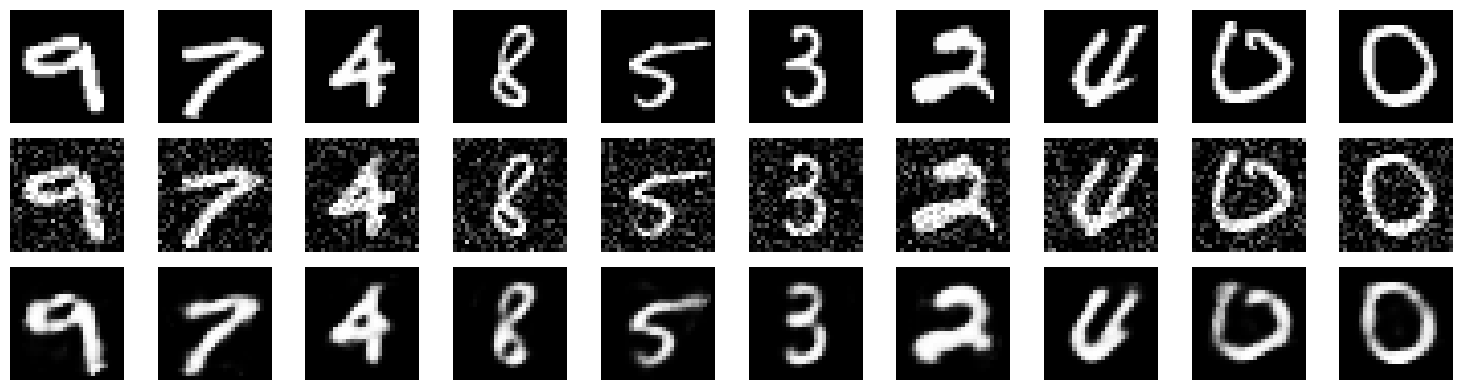

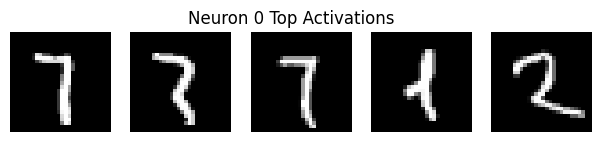

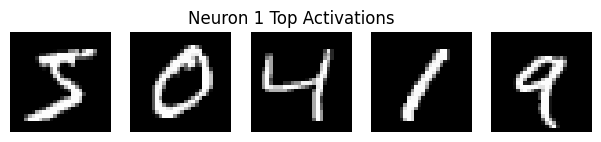

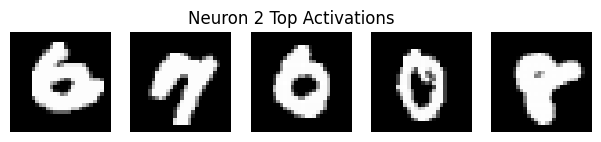

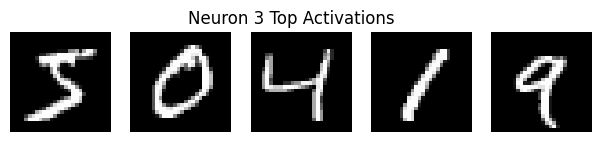

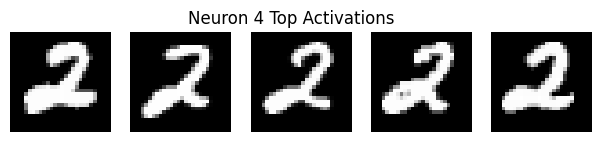

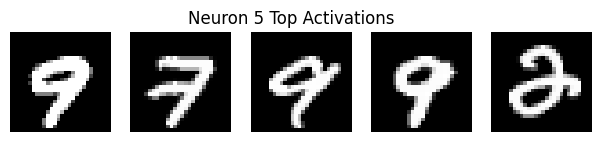

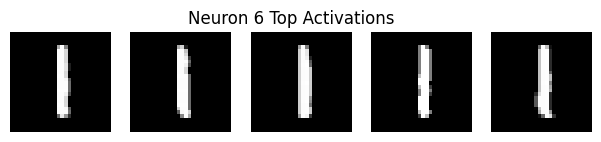

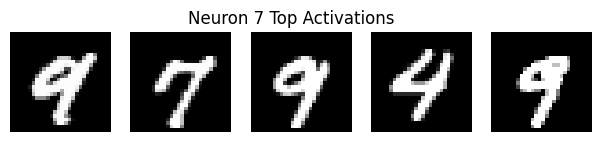

Akurasi dengan pretraining: 0.7566
Akurasi tanpa pretraining: 0.8204


In [4]:
import matplotlib.pyplot as plt

# 1. Visualisasi Rekonstruksi
def show_reconstructions(model, data_loader, n=10):
    model.eval()
    for noisy, clean in data_loader:
        noisy_imgs, _ = noisy
        clean_imgs, _ = clean
        with torch.no_grad():
            reconstructed = model(noisy_imgs)
        break

    fig, axs = plt.subplots(3, n, figsize=(n*1.5, 4))
    for i in range(n):
        axs[0, i].imshow(clean_imgs[i].squeeze(), cmap="gray")
        axs[1, i].imshow(noisy_imgs[i].squeeze(), cmap="gray")
        axs[2, i].imshow(reconstructed[i].squeeze(), cmap="gray")
        axs[0, i].axis("off")
        axs[1, i].axis("off")
        axs[2, i].axis("off")
    axs[0, 0].set_ylabel("Original")
    axs[1, 0].set_ylabel("Noisy")
    axs[2, 0].set_ylabel("Reconstructed")
    plt.tight_layout()
    plt.show()

show_reconstructions(autoencoder, train_loader)

# 2. Visualisasi Aktivasi Coding Layer
def visualize_activations(model, dataset, num_neurons=8, top_k=5):
    model.eval()
    activations = [[] for _ in range(num_neurons)]

    for img, _ in dataset:
        input_img = img.unsqueeze(0)
        with torch.no_grad():
            code = model.encoder(input_img)
        for i in range(num_neurons):
            activations[i].append((code[0, i].item(), img))

    for neuron_id in range(num_neurons):
        top_imgs = sorted(activations[neuron_id], key=lambda x: x[0], reverse=True)[:top_k]
        fig, axs = plt.subplots(1, top_k, figsize=(top_k*1.5, 1.5))
        fig.suptitle(f"Neuron {neuron_id} Top Activations")
        for i, (_, img) in enumerate(top_imgs):
            axs[i].imshow(img.squeeze(), cmap="gray")
            axs[i].axis("off")
        plt.show()

visualize_activations(autoencoder, mnist_train, num_neurons=8, top_k=5)

# 3. Klasifikasi Menggunakan Encoder
class Classifier(nn.Module):
    def __init__(self, encoder, pretrained=True):
        super().__init__()
        if pretrained:
            self.encoder = encoder.encoder
        else:
            self.encoder = nn.Sequential(
                nn.Flatten(),
                nn.Linear(28*28, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU()
            )
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# Hanya 500 data
subset_size = 500
train_subset = torch.utils.data.Subset(mnist_train, list(range(subset_size)))
train_loader_small = DataLoader(train_subset, batch_size=64, shuffle=True)

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            preds = model(x)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

def train_classifier(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            preds = model(x)
            loss = criterion(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return evaluate(model, test_loader)

# Dengan pretraining
model_pretrained = Classifier(autoencoder, pretrained=True)
acc_pretrained = train_classifier(model_pretrained, train_loader_small, test_loader)

# Tanpa pretraining
model_scratch = Classifier(autoencoder, pretrained=False)
acc_scratch = train_classifier(model_scratch, train_loader_small, test_loader)

print(f"Akurasi dengan pretraining: {acc_pretrained:.4f}")
print(f"Akurasi tanpa pretraining: {acc_scratch:.4f}")

Setting up environment and data...

Training denoising autoencoder...
Epoch 1/10, Loss: 0.0534
Epoch 2/10, Loss: 0.0271
Epoch 3/10, Loss: 0.0213
Epoch 4/10, Loss: 0.0180
Epoch 5/10, Loss: 0.0157
Epoch 6/10, Loss: 0.0142
Epoch 7/10, Loss: 0.0132
Epoch 8/10, Loss: 0.0124
Epoch 9/10, Loss: 0.0117
Epoch 10/10, Loss: 0.0113

Visualizing results...


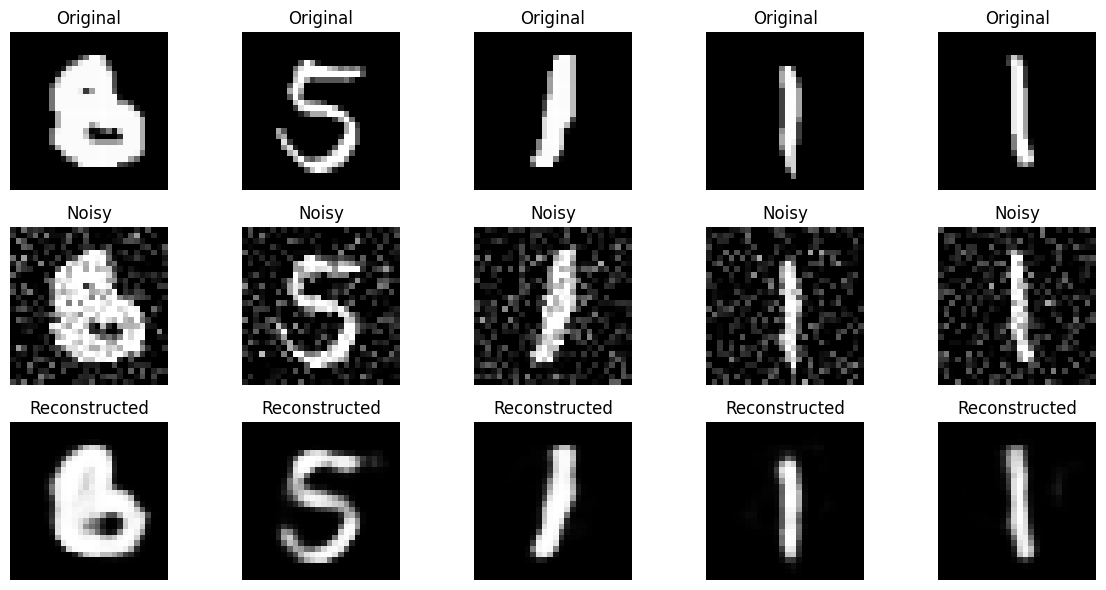

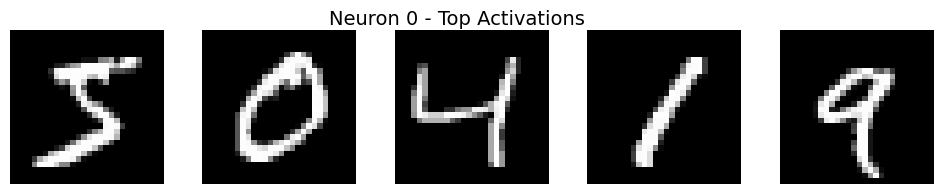

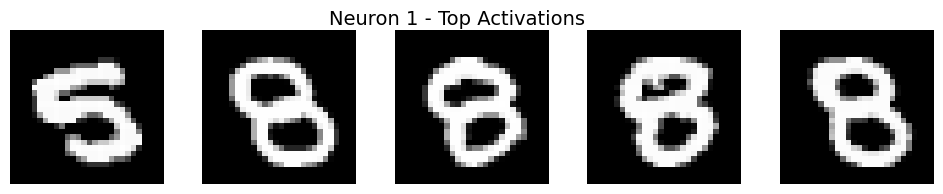

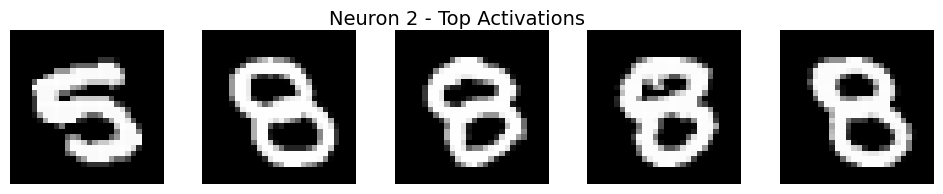

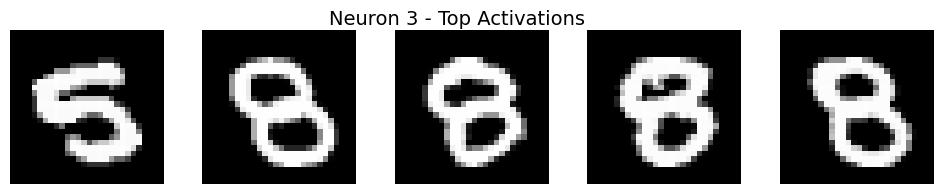

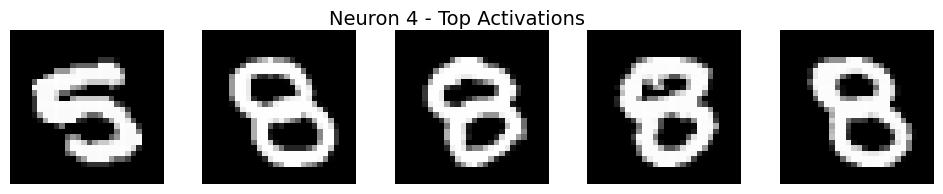

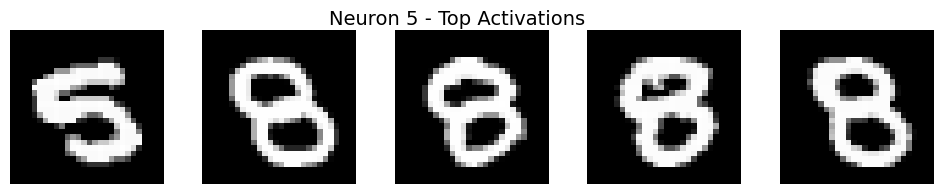

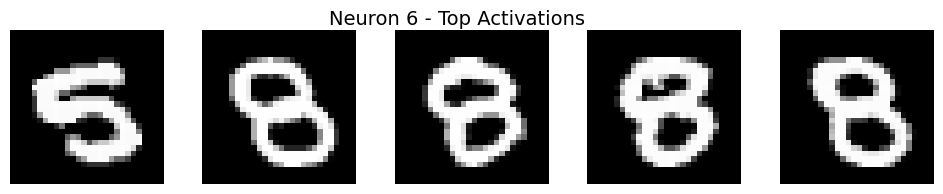

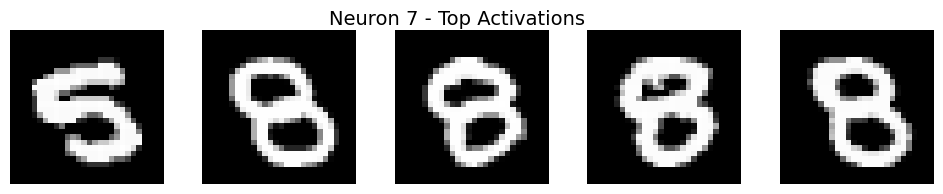


Training classifiers for comparison...

Transfer Learning Accuracy: 0.4522
Scratch Training Accuracy: 0.8314


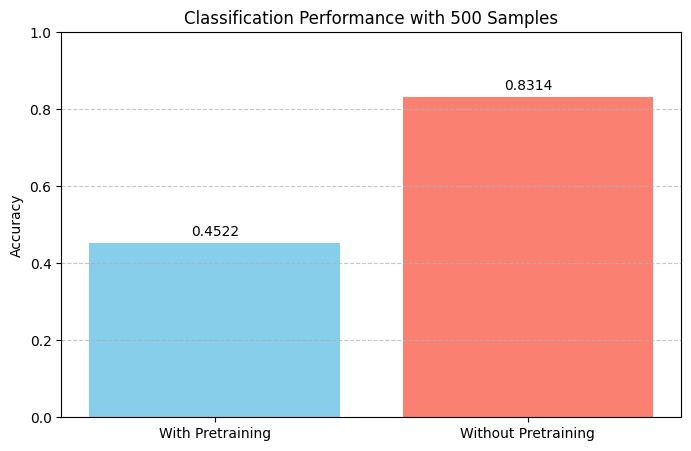

In [5]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ======================
# 1. Setup & Preparation
# ======================
print("Setting up environment and data...")

# Add Gaussian noise to images
class AddGaussianNoise:
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * 0.2
        return torch.clamp(tensor + noise, 0., 1.)

# Define transforms
transform = transforms.Compose([transforms.ToTensor()])
noisy_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise()
])

# Load and prepare datasets
mnist_train = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
mnist_train_noisy = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=noisy_transform
)
mnist_test = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create dataloaders
train_loader = DataLoader(
    list(zip(mnist_train_noisy, mnist_train)),
    batch_size=128,
    shuffle=True
)
test_loader = DataLoader(mnist_test, batch_size=128)

# =============================
# 2. Denoising Autoencoder Model
# =============================
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # Coding layer
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        code = self.encoder(x)
        return self.decoder(code)

# =====================
# 3. Train Autoencoder
# =====================
print("\nTraining denoising autoencoder...")
autoencoder = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(10):
    epoch_loss = 0
    for (noisy, clean) in train_loader:
        noisy_imgs, _ = noisy
        clean_imgs, _ = clean

        optimizer.zero_grad()
        output = autoencoder(noisy_imgs)
        loss = criterion(output, clean_imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/10, Loss: {epoch_loss/len(train_loader):.4f}")

# ==========================
# 4. Visualization Functions
# ==========================
def show_reconstructions(model, data_loader, n=5):
    """Visualize original, noisy, and reconstructed images"""
    model.eval()
    for (noisy, clean) in data_loader:
        noisy_imgs, _ = noisy
        clean_imgs, _ = clean

        with torch.no_grad():
            reconstructed = model(noisy_imgs[:n])

        fig, axs = plt.subplots(3, n, figsize=(12, 6))
        for i in range(n):
            axs[0, i].imshow(clean_imgs[i].squeeze(), cmap='gray')
            axs[0, i].set_title("Original")
            axs[0, i].axis('off')

            axs[1, i].imshow(noisy_imgs[i].squeeze(), cmap='gray')
            axs[1, i].set_title("Noisy")
            axs[1, i].axis('off')

            axs[2, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axs[2, i].set_title("Reconstructed")
            axs[2, i].axis('off')

        plt.tight_layout()
        plt.show()
        break

def visualize_activations(model, dataset, num_neurons=8, top_k=5):
    """Visualize images that activate neurons the most"""
    model.eval()
    activations = [[] for _ in range(num_neurons)]

    for img, _ in dataset:
        with torch.no_grad():
            code = model.encoder(img.unsqueeze(0))
        for i in range(num_neurons):
            activations[i].append((code[0, i].item(), img))

    for neuron_id in range(num_neurons):
        top_imgs = sorted(activations[i], key=lambda x: x[0], reverse=True)[:top_k]
        fig, axs = plt.subplots(1, top_k, figsize=(12, 2))
        fig.suptitle(f"Neuron {neuron_id} - Top Activations", fontsize=14)
        for i, (_, img) in enumerate(top_imgs):
            axs[i].imshow(img.squeeze(), cmap='gray')
            axs[i].axis('off')
        plt.show()

# Run visualizations
print("\nVisualizing results...")
show_reconstructions(autoencoder, train_loader)
visualize_activations(autoencoder, mnist_train)

# ===================================
# 5. Classification with Transfer Learning
# ===================================
print("\nTraining classifiers for comparison...")

# Create small training set (500 samples)
small_train_set, _ = random_split(mnist_train, [500, len(mnist_train)-500])
small_loader = DataLoader(small_train_set, batch_size=64, shuffle=True)

# Classifier model using pretrained encoder
class TransferClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        # Freeze encoder weights
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(64, 10)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# Classifier without pretraining
class FreshClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

# Training function for classifiers
def train_and_evaluate(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)
            correct += (preds.argmax(dim=1) == y).sum().item()
            total += y.size(0)
    return correct / total

# Train and compare both classifiers
pretrained_model = TransferClassifier(autoencoder.encoder)
pretrained_acc = train_and_evaluate(pretrained_model, small_loader, test_loader)

scratch_model = FreshClassifier()
scratch_acc = train_and_evaluate(scratch_model, small_loader, test_loader)

# ================
# 6. Show Results
# ================
print("\n" + "="*50)
print(f"Transfer Learning Accuracy: {pretrained_acc:.4f}")
print(f"Scratch Training Accuracy: {scratch_acc:.4f}")
print("="*50)

# Visualization of accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(["With Pretraining", "Without Pretraining"],
        [pretrained_acc, scratch_acc],
        color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Classification Performance with 500 Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([pretrained_acc, scratch_acc]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.show()